# Nettoyer un texte: approche bag-of-words (exercices)

<a href="https://github.com/linogaliana/python-datascientist/blob/master/notebooks/course/NLP/02_exoclean.ipynb" class="github"><i class="fab fa-github"></i></a>
[![Download](https://img.shields.io/badge/Download-Notebook-important?logo=Jupyter.png)](https://downgit.github.io/#/home?url=https://github.com/linogaliana/python-datascientist/blob/master/notebooks/course/NLP/02_exoclean.ipynb)
[![nbviewer](https://img.shields.io/badge/Visualize-nbviewer-blue?logo=Jupyter.png)](https://nbviewer.jupyter.org/github/linogaliana/python-datascientist/blob/master/notebooks/course/NLP/02_exoclean.ipynb)
[![Onyxia](https://img.shields.io/badge/SSPcloud-Tester%20via%20SSP--cloud-informational&color=yellow?logo=Python.png)](https://datalab.sspcloud.fr/launcher/inseefrlab-helm-charts-datascience/jupyter?autoLaunch=true&onyxia.friendlyName=%C2%ABpython-datascience%C2%BB&init.personalInit=%C2%ABhttps%3A%2F%2Fraw.githubusercontent.com%2Flinogaliana%2Fpython-datascientist%2Fmaster%2Fsspcloud%2Finit-jupyter.sh%C2%BB&init.personalInitArgs=%C2%ABnotebooks/course/NLP%2002_exoclean.ipynb%C2%BB&security.allowlist.enabled=false)<br>
[![Binder](https://img.shields.io/badge/Launch-Binder-E66581.svg?logo=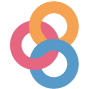.png)](https://mybinder.org/v2/gh/linogaliana/python-datascientist/master?filepath=notebooks/course/NLP/02_exoclean.ipynb)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](http://colab.research.google.com/github/linogaliana/python-datascientist/blob/master/notebooks/course/NLP/02_exoclean.ipynb)
[![githubdev](https://img.shields.io/static/v1?logo=visualstudiocode&label=&message=Open%20in%20Visual%20Studio%20Code&labelColor=2c2c32&color=007acc&logoColor=007acc.png)](https://github.dev/linogaliana/python-datascientist/notebooks/course/NLP/02_exoclean.ipynb)

Cette page approfondit certains aspects présentés dans la
[partie introductive](#nlp). Après avoir travaillé sur le
*Comte de Monte Cristo*, on va continuer notre exploration de la littérature
avec cette fois des auteurs anglophones :

-   Edgar Allan Poe, (EAP) ;
-   HP Lovecraft (HPL) ;
-   Mary Wollstonecraft Shelley (MWS).

Les données sont disponibles ici : [spooky.csv](https://github.com/GU4243-ADS/spring2018-project1-ginnyqg/blob/master/data/spooky.csv) et peuvent être requétées via l’url
<https://github.com/GU4243-ADS/spring2018-project1-ginnyqg/raw/master/data/spooky.csv>.

Le but va être dans un premier temps de regarder dans le détail les termes les plus fréquemment utilisés par les auteurs, de les représenter graphiquement.
On prendra appui sur l’approche *bag of words* présentée dans le chapitre précédent[1].

Ce notebook est librement inspiré de :

-   https://www.kaggle.com/enerrio/scary-nlp-with-spacy-and-keras
-   https://github.com/GU4243-ADS/spring2018-project1-ginnyqg
-   https://www.kaggle.com/meiyizi/spooky-nlp-and-topic-modelling-tutorial/notebook

Les chapitres suivants permettront d’introduire aux enjeux de modélisation
de corpus textuels. Dans un premier temps, le modèle LDA permettra d’explorer
le principe des modèles bayésiens à couche cachés pour modéliser les sujets (*topics*)
présents dans un corpus et segmenter ces topics selon les mots qui les composent.

Le dernier chapitre de la partie visera à
prédire quel texte correspond à quel auteur à partir d’un modèle `Word2Vec`.
Cela sera un pas supplémentaire dans la formalisation puisqu’il s’agira de
représenter chaque mot d’un texte sous forme d’un vecteur de grande dimension, ce
qui nous permettra de rapprocher les mots entre eux dans un espace complexe.

## Librairies nécessaires

Cette page évoquera les principales librairies pour faire du NLP, notamment :

-   [WordCloud](https://github.com/amueller/word_cloud)
-   [nltk](https://www.nltk.org/)
-   [spacy](https://spacy.io/)
-   [Keras](https://keras.io/)
-   [TensorFlow](https://www.tensorflow.org/)

Il faudra également installer les librairies `gensim` et `pywaffle`

{{% box status=“warning” title=“Attention” icon=“fa fa-exclamation-triangle” %}}
Comme dans la [partie précédente](#nlp), il faut télécharger quelques éléments pour que `NTLK` puisse fonctionner correctement. Pour cela, faire :

``` {python}
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('genesis')
nltk.download('wordnet')
nltk.download('omw-1.4')
```

{{% /box %}}

La liste des modules à importer est assez longue, la voici :

[1] L’approche *bag of words* est déjà, si on la pousse à ses limites, très intéressante. Elle peut notamment
faciliter la mise en cohérence de différents corpus
par la méthode des appariements flous
(cf. [Galiana et al. 2022](https://epic-davinci-acb57b.netlify.app/#1).
Le [chapitre sur ElasticSearch](#elastic) présent dans cette partie du cours présente quelques
éléments de ce travail sur les données de l’`OpenFoodFacts`

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import base64
import string
import re
import nltk

from collections import Counter
from time import time
# from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS as stopwords
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
#!pip install pywaffle
from pywaffle import Waffle

from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('genesis')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /github/home/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /github/home/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package genesis to /github/home/nltk_data...

[nltk_data]   Unzipping corpora/genesis.zip.
[nltk_data] Downloading package wordnet to /github/home/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.

[nltk_data] Downloading package omw-1.4 to /github/home/nltk_data...

[nltk_data]   Unzipping corpora/omw-1.4.zip.

True

## Données utilisées

{{% box status=“exercise” title=“Exercice” icon=“fas fa-pencil-alt” %}}

**Exercice 1 : Importer les données spooky** \[OPTIONNEL\]

*Pour ceux qui ont envie de tester leurs connaissances en pandas*

1.  Importer le jeu de données `spooky` à partir de l’URL <https://github.com/GU4243-ADS/spring2018-project1-ginnyqg/raw/master/data/spooky.csv> sous le nom `train`. L’encoding est `latin-1`

2.  Mettre des majuscules au nom des colonnes.

3.  Retirer le prefix `id` de la colonne `Id` et appeler la nouvelle colonne `ID`.

4.  Mettre l’ancienne colonne `Id` en index.

{{% /box %}}

Si vous ne faites pas l’exercice 1, pensez à charger les données en executant la fonction `get_data.py` :

In [8]:
import requests

url = 'https://raw.githubusercontent.com/linogaliana/python-datascientist/master/content/course/NLP/get_data.py'
r = requests.get(url, allow_redirects=True)
open('getdata.py', 'wb').write(r.content)

import getdata
train = getdata.create_train_dataframes()

Ce code introduit une base nommée `train` dans l’environnement.

Le jeu de données met ainsi en regard un auteur avec une phrase qu’il a écrite :

In [9]:
train.head()

,Text,Author,ID
Id,,,
id26305,"This process, however, afforded me no means of...",EAP,26305
id17569,It never once occurred to me that the fumbling...,HPL,17569
id11008,"In his left hand was a gold snuff box, from wh...",EAP,11008
id27763,How lovely is spring As we looked from Windsor...,MWS,27763
id12958,"Finding nothing else, not even gold, the Super...",HPL,12958


On peut se rendre compte que les extraits des 3 auteurs ne sont pas forcément équilibrés dans le jeu de données. Il faudra en tenir compte dans la prédiction.

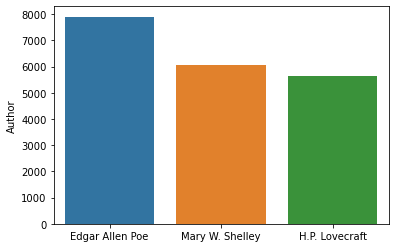

In [12]:
g.figure.get_figure()

{{% box status=“hint” title=“Hint” icon=“fa fa-lightbulb” %}}
L’approche *bag of words* est présentée de
manière plus extensive dans le [chapitre précédent](#nlp).

L’idée est d’étudier la fréquence des mots d’un document et la
surreprésentation des mots par rapport à un document de
référence (appelé *corpus*).

Cette approche un peu simpliste mais très
efficace : on peut calculer des scores permettant par exemple de faire
de classification automatique de document par thème, de comparer la
similarité de deux documents. Elle est souvent utilisée en première analyse,
et elle reste la référence pour l’analyse de textes mal
structurés (tweets, dialogue tchat, etc.).

Les analyses tf-idf (*term frequency-inverse document frequency*) ou les
constructions d’indices de similarité cosinus reposent sur ce type d’approche
{{% /box %}}

## Fréquence d’un mot

Avant de s’adonner à une analyse systématique du champ lexical de chaque
auteur, on se focaliser dans un premier temps sur un unique mot, le mot *fear*.

{{% box status=“note” title=“Note” icon=“fa fa-comment” %}}
L’exercice ci-dessous présente une représentation graphique nommée
*waffle chart*. Il s’agit d’une représentation graphique préférable aux
camemberts qui sont des graphiques manipulables car l’oeil humain se laisse
facilement berner par cette représentation graphique qui ne respecte pas
les proportions.
{{% /box %}}

{{% box status=“exercise” title=“Exercice” icon=“fas fa-pencil-alt” %}}

**Exercice 2 : Fréquence d’un mot**

1.  Compter le nombre de phrases, pour chaque auteur, où apparaît le mot `fear`.

,wordtoplot
Author,
EAP,70
HPL,160
MWS,211


1.  Utiliser `pywaffle` pour obtenir les graphiques ci-dessous qui résument
    de manière synthétique le nombre d’occurrences du mot *“fear”* par auteur.

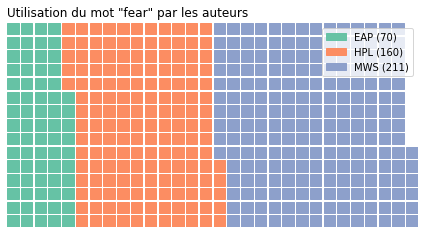

1.  Refaire l’analyse avec le mot *“horror”*.

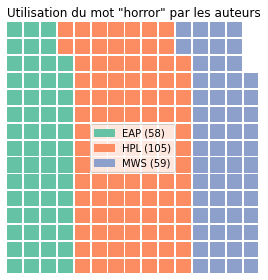

La peur est ainsi plus évoquée par Mary Shelley
(sentiment assez naturel face à la créature du docteur Frankenstein) alors
que Lovecraft n’a pas volé sa réputation d’écrivain de l’horreur !

{{% /box %}}

## Premier *wordcloud*

Pour aller plus loin dans l’analyse du champ lexical de chaque auteur,
on peut représenter un `wordcloud` qui permet d’afficher chaque mot avec une
taille proportionnelle au nombre d’occurrence de celui-ci.

{{% box status=“exercise” title=“Exercice” icon=“fas fa-pencil-alt” %}}

**Exercice 3 : Wordcloud**

1.  En utilisant la fonction `wordCloud`, faire trois nuages de mot pour représenter les mots les plus utilisés par chaque auteur.

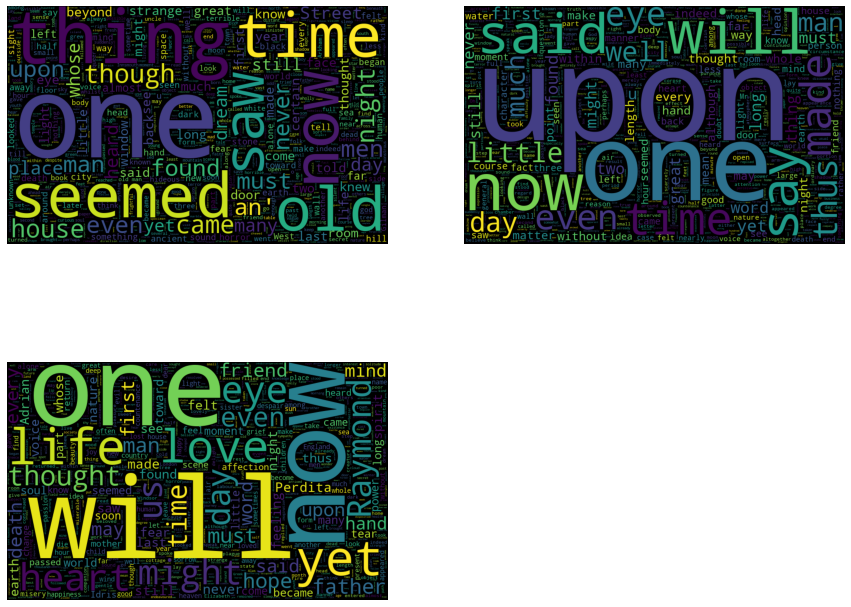

1.  Calculer les 25 mots plus communs pour chaque auteur et représenter les trois histogrammes des décomptes.

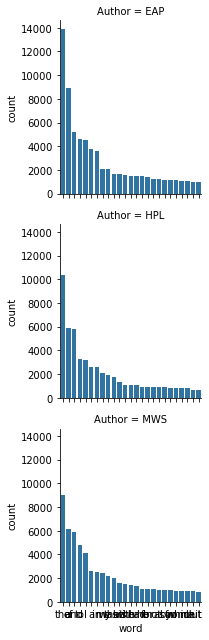

On voit ici que ce sont des mots communs, comme *“the”*, *“of”*, etc. sont très
présents. Mais ils sont peu porteurs d’information, on peut donc les éliminer
avant de faire une analyse syntaxique poussée.
Ceci est une démonstration par l’exemple qu’il vaut mieux nettoyer le texte avant de
l’analyser (sauf si on est intéressé
par la loi de Zipf, cf. exercice suivant).

{{% /box %}}

## Aparté: la loi de Zipf

{{% box status=“hint” title=“La loi de Zipf” icon=“fa fa-lightbulb” %}}
Dans son sens strict, la loi de Zipf prévoit que
dans un texte donné, la fréquence d’occurrence $f(n_i)$ d’un mot est
liée à son rang $n_i$ dans l’ordre des fréquences par une loi de la forme
$f(n_i) = c/n_i$ où $c$ est une constante. Zipf, dans les années 1930, se basait sur l’oeuvre
de Joyce, *Ulysse* pour cette affirmation.

Plus généralement, on peut dériver la loi de Zipf d’une distribution exponentielle des fréquences: $f(n_i) = cn_{i}^{-k}$. Cela permet d’utiliser la famille des modèles linéaires généralisés, notamment les régressions poissonniennes, pour mesurer les paramètres de la loi. Les modèles linéaire traditionnels en `log` souffrent en effet, dans ce contexte, de biais (la loi de Zipf est un cas particulier d’un modèle gravitaire, où appliquer des OLS est une mauvaise idée, cf. [Galiana et al. (2020)](https://linogaliana.netlify.app/publication/2020-segregation/) pour les limites).

On va estimer le modèle suivant par GLM via `statsmodels`:

$$
\mathbb{E}\bigg( f(n_i)|n_i \bigg) = \exp(\beta_0 + \beta_1 \log(n_i))
$$

Prenons les résultats de l’exercice précédent et enrichissons les du rang et de la fréquence d’occurrence d’un mot :

In [22]:
count_words = pd.DataFrame({'counter' : train
    .groupby('Author')
    .apply(lambda s: ' '.join(s['Text']).split())
    .apply(lambda s: Counter(s))
    .apply(lambda s: s.most_common())
    .explode()}
)
count_words[['word','count']] = pd.DataFrame(count_words['counter'].tolist(), index=count_words.index)
count_words = count_words.reset_index()

count_words = count_words.assign(
    tot_mots_auteur = lambda x: (x.groupby("Author")['count'].transform('sum')),
    freq = lambda x: x['count'] /  x['tot_mots_auteur'],
    rank = lambda x: x.groupby("Author")['count'].transform('rank', ascending = False)
)

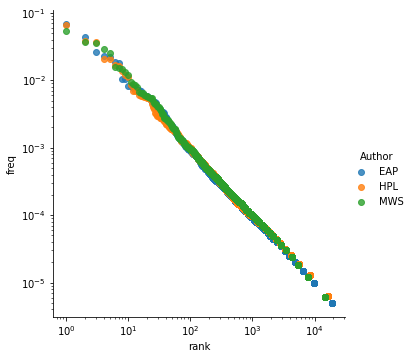

In [24]:
g.figure.get_figure()

In [25]:
import statsmodels.api as sm

exog = sm.add_constant(np.log(count_words['rank'].astype(float)))

model = sm.GLM(count_words['freq'].astype(float), exog, family = sm.families.Poisson()).fit()

# Afficher les résultats du modèle
print(model.summary().as_html())

<table class="simpletable">
<caption>Generalized Linear Model Regression Results</caption>
<tr>
  <th>Dep. Variable:</th>         <td>freq</td>       <th>  No. Observations:  </th>  <td> 69301</td>  
</tr>
<tr>
  <th>Model:</th>                  <td>GLM</td>       <th>  Df Residuals:      </th>  <td> 69299</td>  
</tr>
<tr>
  <th>Model Family:</th>         <td>Poisson</td>     <th>  Df Model:          </th>  <td>     1</td>  
</tr>
<tr>
  <th>Link Function:</th>          <td>Log</td>       <th>  Scale:             </th> <td>  1.0000</td> 
</tr>
<tr>
  <th>Method:</th>                <td>IRLS</td>       <th>  Log-Likelihood:    </th> <td> -23.011</td> 
</tr>
<tr>
  <th>Date:</th>            <td>Wed, 25 May 2022</td> <th>  Deviance:          </th> <td>0.065676</td> 
</tr>
<tr>
  <th>Time:</th>                <td>12:50:32</td>     <th>  Pearson chi2:      </th>  <td>0.0656</td>  
</tr>
<tr>
  <th>No. Iterations:</th>          <td>5</td>        <th>  Pseudo R-squ. (CS):</th> <td>0.0002431<

{{% /box %}}

## Nettoyage d’un texte

Les premières étapes dans le nettoyage d’un texte, qu’on a
développé au cours du [chapitre précédent](#nlp), sont :

-   suppression de la ponctuation
-   suppression des *stopwords*

Cela passe par la tokenisation d’un texte, c’est-à-dire la décomposition
de celui-ci en unités lexicales (les *tokens*). Ces unités lexicales peuvent être de différentes natures, selon l’analyse que l’on désire mener. Ici, on va définir les tokens comme étant les mots utilisés.

Plutôt que de faire soi-même ce travail de nettoyage, avec des fonctions mal optimisées, on peut utiliser la librairie `nltk` comme détaillé [précédemment](#nlp).

{{% box status=“exercise” title=“Exercice” icon=“fas fa-pencil-alt” %}}

**Exercice 4 : Nettoyage du texte**

Repartir de `train`, notre jeu de données d’entraînement. Pour rappel, `train` a la structure suivante:

,Text,Author,ID,wordtoplot
Id,,,,
id26305,"This process, however, afforded me no means of...",EAP,26305,0
id17569,It never once occurred to me that the fumbling...,HPL,17569,0


1.  Tokeniser chaque phrase avec `nltk`. Le `DataFrame` devrait maintenant avoir cet aspect :

ID     Author
00001  MWS       [Idris, was, well, content, with, this, resolv...
00002  HPL       [I, was, faint, even, fainter, than, the, hate...
dtype: object

1.  Retirer les stopwords avec `nltk`.

{{% /box %}}

{{% box status=“hint” title=“Hint” icon=“fa fa-lightbulb” %}}
La méthode `apply` est très pratique ici car nous avons une phrase par ligne. Plutôt que de faire un `DataFrame` par auteur, ce qui n’est pas une approche très flexible, on peut directement appliquer la tokenisation
sur notre `DataFrame` grâce à `apply`, sans le diviser.
{{% /box %}}

Ce petit nettoyage permet d’arriver à un texte plus intéressant en termes d’analyse lexicale. Par exemple, si on reproduit l’analyse précédente… :

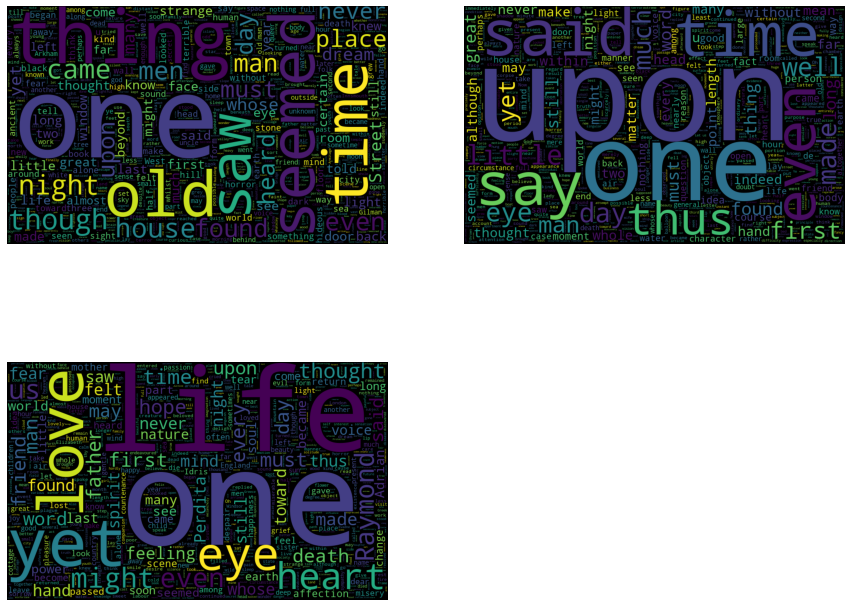

Pour aller plus loin dans l’harmonisation d’un texte, il est possible de
mettre en place les classes d’équivalence développées dans la
[partie précédente](#nlp) afin de remplacer différentes variations d’un même
mot par une forme canonique :

-   la **racinisation** (*stemming*) assez fruste mais rapide, notamment
    en présence de fautes d’orthographe. Dans ce cas, chevaux peut devenir chev
    mais être ainsi confondu avec chevet ou cheveux. Elles est généralement plus simple à mettre en oeuvre, quoique
    plus fruste.

-   la **lemmatisation** qui requiert la connaissance des statuts
    grammaticaux (exemple : chevaux devient cheval).
    Elle est mise en oeuvre, comme toujours avec `nltk`, à travers un
    modèle. En l’occurrence, un `WordNetLemmatizer` (WordNet est une base
    lexicographique ouverte). Par exemple, les mots *“women”*, *“daughters”*
    et *“leaves”* seront ainsi lemmatisés de la manière suivante :

In [31]:
from nltk.stem import WordNetLemmatizer
lemm = WordNetLemmatizer()

for word in ["women","daughters", "leaves"]:
    print("The lemmatized form of %s is: {}".format(lemm.lemmatize(word)) % word)

The lemmatized form of women is: woman
The lemmatized form of daughters is: daughter
The lemmatized form of leaves is: leaf

{{% box status=“note” title=“Note” icon=“fa fa-comment” %}}
Pour disposer du corpus nécessaire à la lemmatisation, il faut, la première fois,
télécharger celui-ci grâce aux commandes suivantes:

``` python
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
```

{{% /box %}}

{{% box status=“exercise” title=“Exercice” icon=“fas fa-pencil-alt” %}}

**Exercice 5 : Lemmatisation avec `nltk` et `spaCy`**

On va se restreindre au corpus d’Edgar Allan Poe et repartir de la base de données
brute :

In [32]:
eap_clean = train[train["Author"] == "EAP"]
eap_clean = ' '.join(eap_clean['Text'])
#Tokenisation naïve sur les espaces entre les mots => on obtient une liste de mots
#tokens = eap_clean.split()
word_list = nltk.word_tokenize(eap_clean)

Utiliser un `WordNetLemmatizer` et observer le résultat.

{{% /box %}}

## TF-IDF: calcul de fréquence

Le calcul [tf-idf](https://fr.wikipedia.org/wiki/TF-IDF) (term frequency–inverse document frequency) permet de calculer un score de proximité entre un terme de recherche et un document (c’est ce que font les moteurs de recherche).

-   La partie `tf` calcule une fonction croissante de la fréquence du terme de recherche dans le document à l’étude ;
-   La partie `idf` calcule une fonction inversement proportionnelle à la fréquence du terme dans l’ensemble des documents (ou corpus).

Le score total, obtenu en multipliant les deux composantes, permet ainsi de donner un score d’autant plus élevé que le terme est surréprésenté dans un document (par rapport à l’ensemble des documents). Il existe plusieurs fonctions, qui pénalisent plus ou moins les documents longs, ou qui sont plus ou moins *smooth*.

{{% box status=“exercise” title=“Exercice” icon=“fas fa-pencil-alt” %}}

**Exercice 6 : TF-IDF: calcul de fréquence**

1.  Utiliser le vectoriseur TfIdF de `scikit-learn` pour transformer notre corpus en une matrice `document x terms`. Au passage, utiliser l’option `stop_words` pour ne pas provoquer une inflation de la taille de la matrice. Nommer le modèle `tfidf` et le jeu entraîné `tfs`.

2.  Après avoir construit la matrice de documents x terms avec le code suivant, rechercher les lignes où les termes ayant la structure `abandon` sont non-nuls.

/miniconda/envs/python-ENSAE/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


,aaem,ab,aback,abaft,abandon,abandoned,abandoning,abandonment,abaout,abased,...,zodiacal,zoilus,zokkar,zone,zones,zopyrus,zorry,zubmizzion,zuro,á¼
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.253506,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Les lignes sont les suivantes :

Int64Index([    4,   116,   215,   571,   839,  1042,  1052,  1069,  2247,
             2317,  2505,  3023,  3058,  3245,  3380,  3764,  3886,  4425,
             5289,  5576,  5694,  6812,  7500,  9013,  9021,  9077,  9560,
            11229, 11395, 11451, 11588, 11827, 11989, 11998, 12122, 12158,
            12189, 13666, 15259, 16516, 16524, 16759, 17547, 18019, 18072,
            18126, 18204, 18251],
           dtype='int64')

,aaem,ab,aback,abaft,abandon,abandoned,abandoning,abandonment,abaout,abased,...,zodiacal,zoilus,zokkar,zone,zones,zopyrus,zorry,zubmizzion,zuro,á¼
4,0.0,0.0,0.0,0.0,0.000000,0.253506,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
116,0.0,0.0,0.0,0.0,0.000000,0.339101,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
215,0.0,0.0,0.0,0.0,0.235817,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
571,0.0,0.0,0.0,0.0,0.000000,0.143788,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
839,0.0,0.0,0.0,0.0,0.285886,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


1.  Trouver les 50 extraits où le score TF-IDF est le plus élevé et l’auteur associé. Vous devriez obtenir le classement suivant:

Author
MWS    22
HPL    15
EAP    13
Name: Text, dtype: int64

Les 10 scores les plus élevés sont les suivants :

In [38]:
print(train.iloc[list_fear[:9]]['Text'].values)

['We could not fear we did not.' '"And now I do not fear death.'
 'Be of heart and fear nothing.' 'I smiled, for what had I to fear?'
 'Indeed I had no fear on her account.'
 'I have not the slightest fear for the result.'
 'At length, in an abrupt manner she asked, "Where is he?" "O, fear not," she continued, "fear not that I should entertain hope Yet tell me, have you found him?'
 '"I fear you are right there," said the Prefect.'
 'I went down to open it with a light heart, for what had I now to fear?']

{{% /box %}}

On remarque que les scores les plus élévés sont soient des extraits courts où le mot apparait une seule fois, soit des extraits plus longs où le mot fear apparaît plusieurs fois.

{{% box status=“note” title=“Note” icon=“fa fa-comment” %}}
La matrice `document x terms` est un exemple typique de matrice sparse puisque, dans des corpus volumineux, une grande diversité de vocabulaire peut être trouvée.  
{{% /box %}}

## Approche contextuelle: les *n-gramms*

{{% box status=“note” title=“Note” icon=“fa fa-comment” %}}
Pour être en mesure de mener cette analyse, il est nécessaire de télécharger un corpus supplémentaire :

In [39]:
import nltk
nltk.download('genesis')
nltk.corpus.genesis.words('english-web.txt')

[nltk_data] Downloading package genesis to /github/home/nltk_data...
[nltk_data]   Package genesis is already up-to-date!

['In', 'the', 'beginning', 'God', 'created', 'the', ...]

{{% /box %}}

Il s’agit maintenant de raffiner l’analyse.

On s’intéresse non seulement aux mots et à leur fréquence, mais aussi aux mots qui suivent. Cette approche est essentielle pour désambiguiser les homonymes. Elle permet aussi d’affiner les modèles “bag-of-words”. Le calcul de n-grams (bigrams pour les co-occurences de mots deux-à-deux, tri-grams pour les co-occurences trois-à-trois, etc.) constitue la méthode la plus simple pour tenir compte du contexte.

`nltk` offre des methodes pour tenir compte du contexte : pour ce faire, nous calculons les n-grams, c’est-à-dire l’ensemble des co-occurrences successives de mots n-à-n. En général, on se contente de bi-grams, au mieux de tri-grams :

-   les modèles de classification, analyse du sentiment, comparaison de documents, etc. qui comparent des n-grams avec n trop grands sont rapidement confrontés au problème de données sparse, cela réduit la capacité prédictive des modèles ;
-   les performances décroissent très rapidement en fonction de n, et les coûts de stockage des données augmentent rapidement (environ n fois plus élevé que la base de données initiale).

{{% box status=“exercise” title=“Exercice” icon=“fas fa-pencil-alt” %}}

**Exercice 7 : n-grams et contexte du mot fear**

On va, rapidement, regarder dans quel contexte apparaît le mot `fear` dans
l’oeuvre d’Edgar Allan Poe (EAP). Pour cela, on transforme d’abord
le corpus EAP en tokens `nltk` :

1.  Utiliser la méthode `concordance` pour afficher le contexte dans lequel apparaît le terme `fear`. La liste devrait ressembler à celle-ci:

Exemples d'occurences du terme 'fear' :
Displaying 24 of 24 matches:
lady seventy years age heard express fear never see Marie observation attracte
ingly well I went open light heart I fear The fact business simple indeed I ma
 Geneva seemed resolved give scruple fear wind No one spoken frequenting house
d propeller must entirely remodelled fear serious accident I mean steel rod va
ud rose amazing velocity I slightest fear result He proceeded observing analyz
His third contempt ambition Indeed I fear account The ceiling gloomy looking o
dverted blush extreme recency date I fear right said Prefect This could refast
loud quick unequal spoken apparently fear well anger three four quite right Sa
oughts Question Oinos freely without fear No path trodden vicinity reach happy
ick darkness shutters close fastened fear robbers I knew could see opening doo
ible game antagonist I even went far fear I occasioned much trouble might glad
dame could easily enter unobserved I fear mesmerized adding im

Même si on peut facilement voir le mot avant et après, cette liste est assez difficile à interpréter car elle recoupe beaucoup d’information.

La `collocation` consiste à trouver les bi-grammes qui
apparaissent le plus fréquemment ensemble. Parmi toutes les paires de deux mots observées, il s’agit de sélectionner, à partir d’un modèle statistique, les “meilleures”.

1.  Sélectionner et afficher les meilleures collocation, par exemple selon le critère du ratio de vraisemblance.

Vous aurez besoin des fonctions `BigramCollocationFinder.from_words` et `BigramAssocMeasures.likelihood_ratio` :

In [42]:
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures

Lorsque deux mots sont fortement associés, cela est parfois dû au fait qu’ils apparaissent rarement. Il est donc parfois nécessaire d’appliquer des filtres, par exemple ignorer les bigrammes qui apparaissent moins de 5 fois dans le corpus.

1.  Refaire la question précédente en utilisant toujours un modèle `BigramCollocationFinder` suivi de la méthode `apply_freq_filter` pour ne conserver que les bigrammes présents au moins 5 fois. Puis, au lieu d’utiliser la méthode de maximum de vraisemblance, testez la méthode `nltk.collocations.BigramAssocMeasures().jaccard`.

Cette liste a un peu plus de sens, on a des noms de personnages, de lieux mais aussi des termes fréquemment employés ensemble (*Chess Player* par exemple).

1.  Ne s’intéresser qu’aux *collocations* qui concernent le mot *fear*

Si on mène la même analyse pour le terme *love*, on remarque que de manière logique, on retrouve bien des sujets généralement accolés au verbe :

In [46]:
collocations_word("love")

[('love', 'me'), ('love', 'he'), ('will', 'love'), ('I', 'love'), ('love', ','), ('you', 'love'), ('the', 'love')]

{{% /box %}}